# SegNet with PyTorch
**References**  
1. https://arxiv.org/abs/1511.00561
2. http://blog.qure.ai/notes/semantic-segmentation-deep-learning-review
3. https://arxiv.org/abs/1409.1556

**Summary:**  

This core trainable segmentation engine consists of an encoder network, a corresponding decoder network followed by a pixel-wise classification layer. The architecture of the encoder network is topologically identical to the 13 convolutional layers in the VGG16 network 

## 1.0 Begin with developing the encoder, a 13 layer VGG16 network for 2-class classification

Dataset: COCO

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

# COCO dataset API
from pycocotools.coco import COCO

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

torch.manual_seed(1)

dataDir='/home/jeff/Documents/data_sets/coco' # modify this path appropriatly to your downloaded coco dataset

In [2]:
class COCO_image_helper(object):
    '''
    This class is designed to geneate a pandas dataframe from the COCO image database.  After initialization, the function
    get_classifier_data is called to generate the dataframe, it can contain two categories of images defined by the
    user in the category1 and category2 variables provided as inputs to the function.  When the class instance is called,
    it will return a dictionary of a single image or batch of images in the torch.tensor format.  These images are loaded
    from the COCO database using the COCO API.
    '''
    def __init__(self, dataDir, dataType, RandomSizedCrop = 224):
        '''
        The COCO_image_helper class is initalized with the data_transoframtions provded below.
        '''
        self.data_transform = transforms.Compose([
                transforms.RandomSizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
                ])
        self.dataDir = dataDir
        self.dataType = dataType
        
        # initialize COCO api for testing instance annotations
        annFile = '{}/annotations/instances_{}.json'.format(self.dataDir, self.dataType)
        self.coco = COCO(annFile)

    def __call__(self, im_Number, im_Label):
        '''
        When the class instance is called,it will return a dictionary of a single image or batch of images in the torch.tensor format.  These images are loaded
        from the COCO database using the COCO API.
        '''
        # if single image is passed to class
        if isinstance(im_Number, (int, long)):
            img = self.coco.loadImgs([im_Number])[0]
            sample = Image.open(os.path.join(self.dataDir, 'images', self.dataType, img['file_name']))
            image_batch = self.data_transform(sample).cuda() # perform image transformations
            image_batch = image_batch.unsqueeze(0) # add 4th dimension to front of image

            # get label, convert to torch tensor
            label = self.label_dict[im_Label] 
            label_batch = torch.tensor(label, dtype=torch.float).cuda() # make label a torch tensor

        else:
            # if a batch of images are passed to the class
            assert (len(im_Number) == len(im_Label)), "images and lables not of same length"
            image_batch = []
            label_batch = []
            for number, label in zip(im_Number, im_Label):
                img = self.coco.loadImgs([number])[0]
                sample = Image.open(os.path.join(self.dataDir, 'images', self.dataType, img['file_name']))
                image = self.data_transform(sample).cuda()
                image = image.unsqueeze(0)
                # if we run into a grayscale image, this will allow us to ignore it when creating a batch
                if image.shape != torch.Size([1, 3, 224, 224]):
                    continue
                image_batch.append(image)

                # get label, convert to torch tensor
                label = self.label_dict[label]
                label = torch.tensor(label, dtype=torch.float).cuda()
                label = label.unsqueeze(0)
                label_batch.append(label)
            
            # concatenate images and labels
            image_batch = torch.cat((image_batch), dim=0)
            label_batch = torch.cat((label_batch), dim=0)

        return {'image': image_batch, 'label': label_batch}

    def get_classifier_data(self, category1 = 'cake', category2 ='zebra'):
        '''
        After initialization, the function get_classifier_data is called to generate the dataframe, it can contain 
        two categories of images defined by the user in the category1 and category2 variables provided as inputs 
        to the function.
        '''
        # make a label dictionary for later
        self.label_dict = {category1: 0, category2: 1}
        
        # get all images containing category 1 (note images may contain both category 1 and 2)
        cat1_and_2_Id = self.coco.getCatIds(catNms=[category1]);
        cat1_and_2_imgIds = self.coco.getImgIds(catIds=cat1_and_2_Id);

        cat2_Id = self.coco.getCatIds(catNms=[category2]);
        cat2_imgIds = self.coco.getImgIds(catIds=cat2_Id);

        # cat 1 and cat 2 should be mutually exclusive
        cat1_imgIds = [p for p in cat1_and_2_imgIds if p not in cat2_imgIds]
        cat2_imgIds = [p for p in cat2_imgIds if p not in cat1_and_2_imgIds]

        # convert to dataframe and add labels
        cat1_df = pd.DataFrame(cat1_imgIds)
        cat1_df['label'] = category1
        cat1_df.columns = ['id', 'label']

        cat2_df = pd.DataFrame(cat2_imgIds)
        cat2_df['label'] = category2
        cat2_df.columns = ['id', 'label']

        # Join together
        data = pd.concat([cat1_df,cat2_df]).reset_index(drop=True)
        
        # shuffle before returning
        shuffled_indices = np.random.permutation(len(data))
        self.shuffled_data = data.iloc[shuffled_indices]

        return self.shuffled_data

In [3]:
# generate training and test data from the COCO dataset
training_read_data = COCO_image_helper(dataDir, 'train2017') # define the parameters for read image function
testing_read_data = COCO_image_helper(dataDir, 'val2017')

training_data = training_read_data.get_classifier_data(category1 = 'cake', category2 ='zebra')# [:3000] # get first 200 images
testing_data = testing_read_data.get_classifier_data(category1 = 'cake', category2 ='zebra')[:15] # get first 15 images

print training_data.head(15)
print testing_data.head(15)

loading annotations into memory...
Done (t=13.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
          id  label
3463  321737  zebra
3890   53178  zebra
4189  505113  zebra
2078  235119   cake
4076   53999  zebra
3666   76971  zebra
885   524710   cake
2378  301494   cake
3084  115300  zebra
3667  183302  zebra
2035   21993   cake
3632  338774  zebra
1850  521182   cake
924   483769   cake
2027  497113   cake
         id  label
206  577149  zebra
103  146358   cake
90   568195   cake
185  491613  zebra
140  486046  zebra
34   277689   cake
100  327592   cake
165  545730  zebra
6    377368   cake
60   434459   cake
173  201676  zebra
62   263969   cake
151  104455  zebra
11   450100   cake
106  517056   cake


## Architecture
During training, the input to our ConvNets is a fixed-size 224 × 224 RGB image.  

The only pre-processing we do is subtracting the mean RGB value, computed on the training set, from each pixel.

The image is passed through a stack of convolutional (conv.) layers, where we use filters with a very small receptive field: 3 × 3 (which is the smallest size to capture the notion of left/right, up/down, center).  In one of the configurations we also utilise 1 × 1 convolution filters, which can be seen as a linear transformation of the input channels (followed by non-linearity). 

The convolution stride is fixed to 1 pixel; the spatial padding of conv. layer input is such that the spatial resolution is preserved after convolution, i.e. the padding is 1 pixel for 3 × 3 conv. layers. 

Spatial pooling is carried out by five max-pooling layers, which follow some of the conv. layers (not all the conv. layers are followed by max-pooling). Max-pooling is performed over a 2 × 2 pixel window, with stride 2.

A stack of convolutional layers (which has a different depth in different architectures) is followed by three Fully-Connected (FC) layers: the first two have 4096 channels each, the third performs 1000-way ILSVRC classification and thus contains 1000 channels (one for each class). 

The final layer is the soft-max layer. 

The configuration of the fully connected layers is the same in all networks.

All hidden layers are equipped with the rectification (ReLU (Krizhevsky et al., 2012)) non-linearity. We  note  that  none  of  our  networks  (except  for  one)  contain  Local  Response  Normalisation (LRN)  normalisation (Krizhevsky et al.,  2012):  as  will  be  shown in  Sect.  4,  such  normalisation does not improve the performance on the  ILSVRC dataset,  but leads to  increased memory consumption and computation time.   Where  applicable,  the  parameters for the LRN layer are  those of (Krizhevsky et al., 2012).

## Training 
The training is carried out by optimising the multinomial logistic regression objective using mini-batch gradient descent (based on back-propagation (LeCun et al., 1989)) with momentum.  

The batch size was set to 256, 

momentum to 0.9.  

The training was regularised by weight decay (the L2 penalty multiplier set to 5·10^-4) and dropout regularisation for the first two fully-connected layers (dropout ratio set to 0.5).

The learning rate was initially set to 10^-2, and then decreased by a factor of 10 when the validation set accuracy stopped improving. 

In total, the learning rate was decreased 3 times, and the learning was stopped after 370 K iterations (74 epochs).  

We conjecture that in spite of the larger number of parameters and the greater depth of our nets compared to (Krizhevsky et al., 2012), the nets required less epochs to converge due to (a) implicit regularisation imposed by greater depth and smaller conv. filter sizes; (b) pre-initialisation of certain layers.

We  began with  training the configuration A (Table 1), shallow enough to be trained with random initialisation. Then, when training deeper architectures, we initialised the first four convolutional layers and the last three fully-connected layers with the layers of net A (the intermediate layers were initialised randomly). We did not decrease the learning rate for the pre-initialised layers, allowing them to change during learning. For random initialisation (where applicable), we sampled the weights from a normal distribution with the zero mean and 10^-2 variance. 

The biases were initialised with zero. 

It is worth noting that after the paper submission we found that it is possible to initialise the weights without pre-training by using the random initialisation procedure of Glorot & Bengio (2010). 

## Pre-processing
To obtain the fixed-size 224 × 224 ConvNet input images, they were randomly cropped from rescaled training images (one crop per image per SGD iteration).  

## Data Augmentation
To further augment the training set, the crops underwent random horizontal flipping and random RGB colour shift (Krizhevsky et al., 2012).

multi-scale training, where each training image is individually rescaled by randomly sampling S from a certain range {S min, S max} (we used S min = 256 and S max = 512). Since objects in images can be of different size, it is beneficial to take this into account during training. This can also be seen as training set augmentation by scale jittering, where a single model is trained to recognise objects over a wide range of scales.  For speed reasons, we trained multi-scale models by fine-tuning all layers of a single-scale model with the same configuration, pre-trained with fixed S = 384.

## Layer Summary  
n-chanels = 3  
len(x) = 256  
len(y) = 256  

Input Image 3 x 256 x 256  
1. conv. 64 kernels with size: n-chanels x 3 x 3 + ReLU
2. conv. 64 kernels with size: 64 x 3 x 3 + ReLU
3. MaxPool 2 × 2 pixel window, with stride 2 (feature map size = 64 X 128 X 128)
4. conv. 128 kernels with size: 64 x 3 x 3 + ReLU
5. conv. 128 kernels with size: 128 x 3 x 3 + ReLU
6. MaxPool 2 × 2 pixel window, with stride 2 (Image Size = 128 X 64 X 64)
7. conv. 256 kernels with size: 128 x 3 x 3 + ReLU
8. conv. 256 kernels with size: 256 x 3 x 3 + ReLU
9. MaxPool 2 × 2 pixel window, with stride 2 (Image Size = 256 X 32 X 32)
10. conv. 512 kernels with size: 256 x 3 x 3 + ReLU
11. conv. 512 kernels with size: 512 x 3 x 3 + ReLU
12. MaxPool 2 × 2 pixel window, with stride 2 (Image Size = 512 X 16 X 16)
13. conv. 512 kernels with size: 512 x 3 x 3 + ReLU
14. conv. 512 kernels with size: 512 x 3 x 3 + ReLU
15. MaxPool 2 × 2 pixel window, with stride 2 (Image Size = 512 X 8 X 8)
16. Reshape (1 X (512 \* 8 \* 8))
16. Fully Connected number of neurons 4096 + ReLU
17. Fully Connected number of neurons 4096 + ReLU
18. Fully Connected number of neurons 1000 + ReLU
19. Softmax

(NOTE: this information does not account for shrinking of images from unpadded convolutions)

In [4]:
# input Image: 3 x 224 x 224
a = (64*(3*3*3))+ \
(64*(64*3*3))
# max pool (2x2 stride 2): 64 X 112 X 112
b = (128*(64*3*3))+ \
(128*(128*3*3))
# max pool (2x2 stride 2): 128 X 56 X 56
c = (256*(128*3*3))+ \
(256*(256*3*3))
# max pool (2x2 stride 2): 256 X 28 X 28
d = (512*(256*3*3))+ \
(512*(512*3*3))
# max pool (2x2 stride 2): 512 X 14 X 14
e = (512*(512*3*3))+ \
(512*(512*3*3))
# max pool (2x2 stride 2): 512 X 7 X 7
# reshape: (1 , (512 * 7 * 7 ))
f = (4096*(512*7*7))+ \
(4096*4096) + \
(4096*1000)

total_num_parameters = a+b+c+d+e+f
print total_num_parameters

133035712


In [5]:
class VGG16(nn.Module):
    '''
    This is an implementation of the 13 layer ConvNet Configuration from VERY DEEP CONVOLUTIONAL NETWORKS
    FOR LARGE-SCALE IMAGE RECOGNITION
    
    Layer Summary

    n-chanels = 3
    len(x) = 224
    len(y) = 224

    Input Image 3 x 224 x 224

    conv. 64 kernels with size: n-chanels x 3 x 3 + ReLU
    conv. 64 kernels with size: 64 x 3 x 3 + ReLU
    MaxPool 2 × 2 pixel window, with stride 2 (feature map size = 64 X 112 X 112)
    conv. 128 kernels with size: 64 x 3 x 3 + ReLU
    conv. 128 kernels with size: 128 x 3 x 3 + ReLU
    MaxPool 2 × 2 pixel window, with stride 2 (Image Size = 128 X 56 X 56)
    conv. 256 kernels with size: 128 x 3 x 3 + ReLU
    conv. 256 kernels with size: 256 x 3 x 3 + ReLU
    MaxPool 2 × 2 pixel window, with stride 2 (Image Size = 256 X 28 X 28)
    conv. 512 kernels with size: 256 x 3 x 3 + ReLU
    conv. 512 kernels with size: 512 x 3 x 3 + ReLU
    MaxPool 2 × 2 pixel window, with stride 2 (Image Size = 512 X 14 X 14)
    conv. 512 kernels with size: 512 x 3 x 3 + ReLU
    conv. 512 kernels with size: 512 x 3 x 3 + ReLU
    MaxPool 2 × 2 pixel window, with stride 2 (Image Size = 512 X 7 X 7)
    Reshape (1 X (512 * 7 * 7))
    Fully Connected number of neurons 4096 + ReLU
    Fully Connected number of neurons 4096 + ReLU
    Fully Connected number of neurons 1000 + ReLU
    Softmax
    
    Total number of parameters = 133k
    '''
    def __init__(self, im_channels, im_H, im_W):
        super(VGG16, self).__init__()
        self.im_H = im_H
        self.im_W = im_W
        self.im_channels = im_channels
        
        # pool layers are all the same, we can define once here
        self.pool = nn.MaxPool2d((2,2), stride = 2).cuda() # kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        
        # drouput layers are all the same and can be defined here
        self.dropout = nn.Dropout(p=0.5, inplace=False)
        
        self.conv1 = nn.Conv2d(3, 64, 3).cuda() #in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True
        self.conv2 = nn.Conv2d(64, 64, 3).cuda()
        
#         self.bn1 = nn.BatchNorm2d(64).cuda()
        self.conv3 = nn.Conv2d(64, 128, 3).cuda() #in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True
        self.conv4 = nn.Conv2d(128, 128, 3).cuda()

#         self.bn2 = nn.BatchNorm2d(128).cuda()
        self.conv5 = nn.Conv2d(128, 256, 3).cuda()
        self.conv6 = nn.Conv2d(256, 256, 3).cuda()
        
        self.conv7 = nn.Conv2d(256, 512, 3).cuda()
        self.conv8 = nn.Conv2d(512, 512, 3).cuda()
        
        self.conv9 = nn.Conv2d(512, 512, 3).cuda()
        self.conv10 = nn.Conv2d(512, 512, 3).cuda()
        
        self.linear1 = nn.Linear(512 * 3 * 3, 4096).cuda()  # in_features, out_features, bias=True)
        self.linear2 = nn.Linear(4096, 4096).cuda()
        self.linear3 = nn.Linear(4096, 1).cuda()

#     def conv_block(self, in_channels, out_channels, kernel_size):
#         nn.Conv2d(in_channels, out_channels, kernel_size).cuda()
#         nn.Conv2d(out_channels, out_channels, kernel_size).cuda()
        
    def forward(self, img, batch_size):
        x = F.relu(self.conv1(img))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool(x)

        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = self.pool(x)

        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = self.pool(x)

        x = x.view(batch_size, 1, -1)

        x = self.dropout(x)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = F.relu(self.linear2(x))
        scores = F.sigmoid(self.linear3(x))

        return scores

In [6]:
# Set parameters for classes used in training model
model = VGG16(3, 224, 224) # define parameters for CNN

# initialize weights
# traverse all Modules, and, upon __class__.__name__ matching, you initialise the parameters with what you prefer.
def weights_init(m):
    classname = m.__class__.__name__ 
    if classname.find('Conv') != -1:
        print 'initializing weights for layer: %s' %(classname)
        torch.nn.init.xavier_uniform_(m.weight.data, gain=1)
        torch.nn.init.normal_(m.bias.data, mean = 0.0, std = 0.1)
    elif classname.find('BatchNorm') != -1:
        print 'initializing weights for layer: %s' %(classname)
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
model = model.apply(weights_init)

loss_function = nn.BCELoss() # try BCEWithLogitsLoss
optimizer = optim.SGD(model.parameters(),lr = 0.01, momentum=0.9, weight_decay = 0.005) # define parameters for optimizer
print model

initializing weights for layer: Conv2d
initializing weights for layer: Conv2d
initializing weights for layer: Conv2d
initializing weights for layer: Conv2d
initializing weights for layer: Conv2d
initializing weights for layer: Conv2d
initializing weights for layer: Conv2d
initializing weights for layer: Conv2d
initializing weights for layer: Conv2d
initializing weights for layer: Conv2d
VGG16(
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5)
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), st

testing results
577149 zebra
tensor(0.3597, device='cuda:0')
tensor(1., device='cuda:0')
146358 cake
tensor(0.3755, device='cuda:0')
tensor(0., device='cuda:0')
568195 cake
tensor(0.3673, device='cuda:0')
tensor(0., device='cuda:0')
491613 zebra
tensor(0.3692, device='cuda:0')
tensor(1., device='cuda:0')
486046 zebra
tensor(0.3687, device='cuda:0')
tensor(1., device='cuda:0')
277689 cake
tensor(0.3654, device='cuda:0')
tensor(0., device='cuda:0')
327592 cake
tensor(0.3777, device='cuda:0')
tensor(0., device='cuda:0')
545730 zebra
tensor(0.3718, device='cuda:0')
tensor(1., device='cuda:0')
377368 cake
tensor(0.3657, device='cuda:0')
tensor(0., device='cuda:0')
434459 cake
tensor(0.3678, device='cuda:0')
tensor(0., device='cuda:0')
201676 zebra
tensor(0.3648, device='cuda:0')
tensor(1., device='cuda:0')
263969 cake
tensor(0.3721, device='cuda:0')
tensor(0., device='cuda:0')
104455 zebra
tensor(0.3784, device='cuda:0')
tensor(1., device='cuda:0')
450100 cake
tensor(0.3776, device='cuda:0'

testing results
577149 zebra
tensor(0.2628, device='cuda:0')
tensor(1., device='cuda:0')
146358 cake
tensor(0.1130, device='cuda:0')
tensor(0., device='cuda:0')
568195 cake
tensor(1.00000e-02 *
       3.6324, device='cuda:0')
tensor(0., device='cuda:0')
491613 zebra
tensor(0.3030, device='cuda:0')
tensor(1., device='cuda:0')
486046 zebra
tensor(0.5056, device='cuda:0')
tensor(1., device='cuda:0')
277689 cake
tensor(0.5595, device='cuda:0')
tensor(0., device='cuda:0')
327592 cake
tensor(1.00000e-02 *
       5.1679, device='cuda:0')
tensor(0., device='cuda:0')
545730 zebra
tensor(0.5596, device='cuda:0')
tensor(1., device='cuda:0')
377368 cake
tensor(0.2529, device='cuda:0')
tensor(0., device='cuda:0')
434459 cake
tensor(1.00000e-02 *
       9.7933, device='cuda:0')
tensor(0., device='cuda:0')
201676 zebra
tensor(0.5302, device='cuda:0')
tensor(1., device='cuda:0')
263969 cake
tensor(0.3709, device='cuda:0')
tensor(0., device='cuda:0')
104455 zebra
tensor(0.5589, device='cuda:0')
tensor(

testing results
577149 zebra
tensor(0.9946, device='cuda:0')
tensor(1., device='cuda:0')
146358 cake
tensor(1.00000e-02 *
       3.5922, device='cuda:0')
tensor(0., device='cuda:0')
568195 cake
tensor(1.00000e-04 *
       5.8286, device='cuda:0')
tensor(0., device='cuda:0')
491613 zebra
tensor(1.00000e-02 *
       2.0098, device='cuda:0')
tensor(1., device='cuda:0')
486046 zebra
tensor(0.1032, device='cuda:0')
tensor(1., device='cuda:0')
277689 cake
tensor(1.00000e-02 *
       2.7945, device='cuda:0')
tensor(0., device='cuda:0')
327592 cake
tensor(1.00000e-03 *
       2.6140, device='cuda:0')
tensor(0., device='cuda:0')
545730 zebra
tensor(0.6039, device='cuda:0')
tensor(1., device='cuda:0')
377368 cake
tensor(1.00000e-02 *
       8.8074, device='cuda:0')
tensor(0., device='cuda:0')
434459 cake
tensor(1.00000e-03 *
       3.4076, device='cuda:0')
tensor(0., device='cuda:0')
201676 zebra
tensor(0.9974, device='cuda:0')
tensor(1., device='cuda:0')
263969 cake
tensor(1.00000e-03 *
       

testing results
577149 zebra
tensor(0.9987, device='cuda:0')
tensor(1., device='cuda:0')
146358 cake
tensor(1.00000e-02 *
       6.9214, device='cuda:0')
tensor(0., device='cuda:0')
568195 cake
tensor(0.1129, device='cuda:0')
tensor(0., device='cuda:0')
491613 zebra
tensor(0.6710, device='cuda:0')
tensor(1., device='cuda:0')
486046 zebra
tensor(0.8420, device='cuda:0')
tensor(1., device='cuda:0')
277689 cake
tensor(0.3578, device='cuda:0')
tensor(0., device='cuda:0')
327592 cake
tensor(1.00000e-02 *
       7.1943, device='cuda:0')
tensor(0., device='cuda:0')
545730 zebra
tensor(0.7730, device='cuda:0')
tensor(1., device='cuda:0')
377368 cake
tensor(0.2263, device='cuda:0')
tensor(0., device='cuda:0')
434459 cake
tensor(1.00000e-03 *
       3.0623, device='cuda:0')
tensor(0., device='cuda:0')
201676 zebra
tensor(0.9891, device='cuda:0')
tensor(1., device='cuda:0')
263969 cake
tensor(1.00000e-03 *
       4.3402, device='cuda:0')
tensor(0., device='cuda:0')
104455 zebra
tensor(0.9682, dev

testing results
577149 zebra
tensor(0.9999, device='cuda:0')
tensor(1., device='cuda:0')
146358 cake
tensor(1.00000e-04 *
       1.7447, device='cuda:0')
tensor(0., device='cuda:0')
568195 cake
tensor(1.00000e-03 *
       6.0794, device='cuda:0')
tensor(0., device='cuda:0')
491613 zebra
tensor(0.8158, device='cuda:0')
tensor(1., device='cuda:0')
486046 zebra
tensor(0.2628, device='cuda:0')
tensor(1., device='cuda:0')
277689 cake
tensor(0.2522, device='cuda:0')
tensor(0., device='cuda:0')
327592 cake
tensor(1.00000e-04 *
       6.9903, device='cuda:0')
tensor(0., device='cuda:0')
545730 zebra
tensor(0.5563, device='cuda:0')
tensor(1., device='cuda:0')
377368 cake
tensor(1.00000e-02 *
       9.7947, device='cuda:0')
tensor(0., device='cuda:0')
434459 cake
tensor(1.00000e-02 *
       1.2102, device='cuda:0')
tensor(0., device='cuda:0')
201676 zebra
tensor(0.9997, device='cuda:0')
tensor(1., device='cuda:0')
263969 cake
tensor(1.00000e-03 *
       4.4320, device='cuda:0')
tensor(0., device

testing results
577149 zebra
tensor(0.9979, device='cuda:0')
tensor(1., device='cuda:0')
146358 cake
tensor(1.00000e-05 *
       4.3504, device='cuda:0')
tensor(0., device='cuda:0')
568195 cake
tensor(1.00000e-04 *
       4.8730, device='cuda:0')
tensor(0., device='cuda:0')
491613 zebra
tensor(0.6058, device='cuda:0')
tensor(1., device='cuda:0')
486046 zebra
tensor(0.4982, device='cuda:0')
tensor(1., device='cuda:0')
277689 cake
tensor(0.3780, device='cuda:0')
tensor(0., device='cuda:0')
327592 cake
tensor(0.2129, device='cuda:0')
tensor(0., device='cuda:0')
545730 zebra
tensor(0.7182, device='cuda:0')
tensor(1., device='cuda:0')
377368 cake
tensor(0.5800, device='cuda:0')
tensor(0., device='cuda:0')
434459 cake
tensor(1.00000e-03 *
       5.4576, device='cuda:0')
tensor(0., device='cuda:0')
201676 zebra
tensor(1.0000, device='cuda:0')
tensor(1., device='cuda:0')
263969 cake
tensor(1.00000e-04 *
       7.6199, device='cuda:0')
tensor(0., device='cuda:0')
104455 zebra
tensor(0.9912, dev

testing results
577149 zebra
tensor(0.9995, device='cuda:0')
tensor(1., device='cuda:0')
146358 cake
tensor(1.00000e-02 *
       8.6968, device='cuda:0')
tensor(0., device='cuda:0')
568195 cake
tensor(1.00000e-03 *
       7.8677, device='cuda:0')
tensor(0., device='cuda:0')
491613 zebra
tensor(0.7657, device='cuda:0')
tensor(1., device='cuda:0')
486046 zebra
tensor(0.7133, device='cuda:0')
tensor(1., device='cuda:0')
277689 cake
tensor(1.00000e-03 *
       1.3044, device='cuda:0')
tensor(0., device='cuda:0')
327592 cake
tensor(1.00000e-04 *
       2.6782, device='cuda:0')
tensor(0., device='cuda:0')
545730 zebra
tensor(0.9251, device='cuda:0')
tensor(1., device='cuda:0')
377368 cake
tensor(0.7049, device='cuda:0')
tensor(0., device='cuda:0')
434459 cake
tensor(1.00000e-05 *
       1.9657, device='cuda:0')
tensor(0., device='cuda:0')
201676 zebra
tensor(0.9998, device='cuda:0')
tensor(1., device='cuda:0')
263969 cake
tensor(1.00000e-02 *
       6.9533, device='cuda:0')
tensor(0., device

testing results
577149 zebra
tensor(0.9984, device='cuda:0')
tensor(1., device='cuda:0')
146358 cake
tensor(1.00000e-04 *
       1.6605, device='cuda:0')
tensor(0., device='cuda:0')
568195 cake
tensor(1.00000e-03 *
       1.0607, device='cuda:0')
tensor(0., device='cuda:0')
491613 zebra
tensor(0.1470, device='cuda:0')
tensor(1., device='cuda:0')
486046 zebra
tensor(0.7786, device='cuda:0')
tensor(1., device='cuda:0')
277689 cake
tensor(1.00000e-02 *
       4.2054, device='cuda:0')
tensor(0., device='cuda:0')
327592 cake
tensor(1.00000e-02 *
       2.0830, device='cuda:0')
tensor(0., device='cuda:0')
545730 zebra
tensor(0.7710, device='cuda:0')
tensor(1., device='cuda:0')
377368 cake
tensor(0.8946, device='cuda:0')
tensor(0., device='cuda:0')
434459 cake
tensor(1.00000e-05 *
       2.1017, device='cuda:0')
tensor(0., device='cuda:0')
201676 zebra
tensor(1.0000, device='cuda:0')
tensor(1., device='cuda:0')
263969 cake
tensor(1.00000e-02 *
       1.2119, device='cuda:0')
tensor(0., device

testing results
577149 zebra
tensor(0.9421, device='cuda:0')
tensor(1., device='cuda:0')
146358 cake
tensor(1.00000e-02 *
       8.9847, device='cuda:0')
tensor(0., device='cuda:0')
568195 cake
tensor(1.00000e-03 *
       7.9514, device='cuda:0')
tensor(0., device='cuda:0')
491613 zebra
tensor(0.2284, device='cuda:0')
tensor(1., device='cuda:0')
486046 zebra
tensor(0.8171, device='cuda:0')
tensor(1., device='cuda:0')
277689 cake
tensor(1.00000e-03 *
       1.9588, device='cuda:0')
tensor(0., device='cuda:0')
327592 cake
tensor(1.00000e-02 *
       4.2607, device='cuda:0')
tensor(0., device='cuda:0')
545730 zebra
tensor(0.8542, device='cuda:0')
tensor(1., device='cuda:0')
377368 cake
tensor(1.00000e-02 *
       2.4926, device='cuda:0')
tensor(0., device='cuda:0')
434459 cake
tensor(1.00000e-04 *
       2.0688, device='cuda:0')
tensor(0., device='cuda:0')
201676 zebra
tensor(0.9952, device='cuda:0')
tensor(1., device='cuda:0')
263969 cake
tensor(1.00000e-02 *
       1.0276, device='cuda:

testing results
577149 zebra
tensor(0.9987, device='cuda:0')
tensor(1., device='cuda:0')
146358 cake
tensor(1.00000e-07 *
       1.5595, device='cuda:0')
tensor(0., device='cuda:0')
568195 cake
tensor(1.00000e-03 *
       1.2226, device='cuda:0')
tensor(0., device='cuda:0')
491613 zebra
tensor(0.9877, device='cuda:0')
tensor(1., device='cuda:0')
486046 zebra
tensor(0.8061, device='cuda:0')
tensor(1., device='cuda:0')
277689 cake
tensor(1.00000e-07 *
       5.7728, device='cuda:0')
tensor(0., device='cuda:0')
327592 cake
tensor(1.00000e-06 *
       6.7172, device='cuda:0')
tensor(0., device='cuda:0')
545730 zebra
tensor(0.8709, device='cuda:0')
tensor(1., device='cuda:0')
377368 cake
tensor(0.3454, device='cuda:0')
tensor(0., device='cuda:0')
434459 cake
tensor(1.00000e-09 *
       1.1133, device='cuda:0')
tensor(0., device='cuda:0')
201676 zebra
tensor(0.9981, device='cuda:0')
tensor(1., device='cuda:0')
263969 cake
tensor(1.00000e-04 *
       1.9764, device='cuda:0')
tensor(0., device

testing results
577149 zebra
tensor(0.9791, device='cuda:0')
tensor(1., device='cuda:0')
146358 cake
tensor(1.00000e-03 *
       2.7427, device='cuda:0')
tensor(0., device='cuda:0')
568195 cake
tensor(1.00000e-02 *
       1.1336, device='cuda:0')
tensor(0., device='cuda:0')
491613 zebra
tensor(0.1738, device='cuda:0')
tensor(1., device='cuda:0')
486046 zebra
tensor(0.1590, device='cuda:0')
tensor(1., device='cuda:0')
277689 cake
tensor(0.3488, device='cuda:0')
tensor(0., device='cuda:0')
327592 cake
tensor(1.00000e-02 *
       4.7264, device='cuda:0')
tensor(0., device='cuda:0')
545730 zebra
tensor(0.3610, device='cuda:0')
tensor(1., device='cuda:0')
377368 cake
tensor(0.1746, device='cuda:0')
tensor(0., device='cuda:0')
434459 cake
tensor(1.00000e-05 *
       2.0396, device='cuda:0')
tensor(0., device='cuda:0')
201676 zebra
tensor(0.9861, device='cuda:0')
tensor(1., device='cuda:0')
263969 cake
tensor(1.00000e-04 *
       2.7833, device='cuda:0')
tensor(0., device='cuda:0')
104455 zeb

<function matplotlib.pyplot.show>

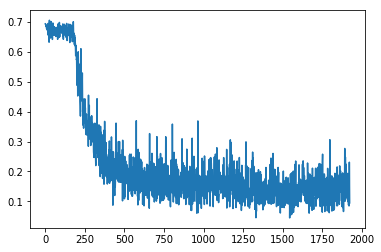

In [7]:
# Start Training
losses = []
num_epochs = 74
batch_size = 180
for epoch in range(num_epochs):  # again, normally you would NOT do 300 epochs, it is toy data
    
    # shuffle data
    shuffled_indices = np.random.permutation(len(training_data))
    training_data = training_data.iloc[shuffled_indices]
    
    #iterate though data
    for batch_num in range(len(training_data)/batch_size):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()
        
        # get lower and upper bound domain of batch
        batch_lower, batch_upper = batch_num*batch_size, (batch_num*batch_size) + batch_size
        
        # Step 2. Get our inputs ready for the network.
        # get image and label data for the batch
        im_Number = training_data['id'][batch_lower: batch_upper].values
        im_Label = training_data['label'][batch_lower: batch_upper].values

        data_dict = training_read_data(im_Number, im_Label)

        in_img = data_dict['image']
        in_label = data_dict['label']
        current_batch_size = len(in_label) # some batches are smaller if we run into a greyscale image.
            
        # Step 3. Run our forward pass.
        score = model(in_img, current_batch_size)
             
        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(score, in_label)
        loss.backward()
        optimizer.step()    # Does the update
        
        # store loss for plot
        loss = torch.Tensor.cpu(loss)
        losses.append(loss.data.numpy())

    # See what the scores are after one epoch of training
    with torch.no_grad():
        print 'testing results'
        for i in range(len(testing_data)):
            
            # Select random training image
            random_Image = testing_data.iloc[i]
            print random_Image['id'], random_Image['label']

            data_dict = testing_read_data(random_Image['id'], random_Image['label'])
            in_img = data_dict['image']
            in_label = data_dict['label']

            # Step 3. Run our forward pass.
            try:
                score = model(in_img, 1)
            except RuntimeError:
                print "ran into greyscale image %i, skipping" %(im_Number)
                continue

            # print result
            print score[0][0][0]
            print in_label[0]

# print loss over each batch
fix, ax = plt.subplots()
ax.plot(losses)
plt.show

## 2.0 Develop the decoder and pixel-wise classification layer